In [1]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [2]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

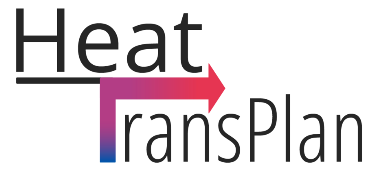


<div style="text-align: center; font-size: 50px;">
    <b>Energy and Sensor mapping on Process Data</b>
</div>

## Index
- [Define Paths and Load Datasets](#define-paths-and-load-datasets)
    - [Define Paths](#define-paths)
    - [Load Datasets](#load-datasets)
    - [Data Transformation and Cleaning](#data-transformation-and-cleaning)
- [Merge Datasets](#merge-datasets)
- [Map Energy Data to Activities](#map-energy-data-to-activities)
    - [Map Electricity & Steam to each Activity](#map-electricity--steam-to-each-activity)
        - [Electricity](#electricity)
        - [Steam](#steam)
    - [Calculate Electricity and Steam Consmption for the whole Process](#calculate-electricity-and-steam-consumption-for-the-whole-process)
- [Merge Sensor Data](#merge-sensor-data)
    - [Merge Sensor Data on Activity Level](#merge-sensor-data-on-activity-level)
    - [Merge Sensor Data on Process Level](#merge-sensor-data-on-process-level)


In [ ]:

import random
import itertools
import os
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
from pathlib import Path
import pm4py
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Define Paths and Load Datasets

## Define Paths

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_bronze = current_path.parent/ 'data' / 'bronze' / 'eckes_granini'

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/silver/aixit' folder relative to the current path
files_folder_silver = current_path.parent / 'data' / 'silver' / 'company_1'


## Load Datasets

In [ ]:
# load Aufträge PET2 08_2024
df = pd.read_excel(files_folder_bronze/"Aufträge Energie Meldungen/Aufträge PET2 08_2024.xlsx", header=1, parse_dates=["StartTime", "EndTime"])
print(df.columns)



df = df.rename(columns={
    "OrderNumber": "case_id",
    "BF Product": "attr_product",
    "BF Number": "attr_product_id",
    "StartTime": "timestamp_start",
    "EndTime": "timestamp_end",
    "ActualQuantity": "attr_quantity",
    "SFG Product": "attr_sfg_product_info",
    "SFG Brix-Density": "attr_sfg_brix_density",
})

time_min = df['timestamp_start'].min()
time_max = df['timestamp_end'].max()

df['object'] = 'order'
df['higher_level_activity'] = None
df['object_type'] = 'material_flow'
df['activity'] = 'production'

df['object_attributes'] = df.apply(
    lambda row: {col: row[col] for col in df.columns if col.startswith('attr')},
    axis=1
)

df = df[['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object','object_type',  'higher_level_activity', 'object_attributes']]

df_object_1 = df.copy()

df.head()

Index(['OrderNumber', 'BF Product', 'BF Number', 'StartTime', 'EndTime',
       'ActualQuantity', 'SFG Product', 'SFG Brix-Density', 'Unnamed: 8'],
      dtype='object')


,case_id,activity,timestamp_start,timestamp_end,object,object_type,higher_level_activity,object_attributes
0,10705690,production,2024-08-01 07:41:45,2024-08-01 13:28:09,order,material_flow,None,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
1,10705688,production,2024-08-01 13:46:24,2024-08-01 15:47:52,order,material_flow,None,"{'attr_product': 'BF 1,00 GR WeißeGrapefr N D0..."
2,10705695,production,2024-08-01 16:21:32,2024-08-01 21:33:50,order,material_flow,None,"{'attr_product': 'BF 1,00 GR PinkGrapefruit D ..."
3,10705698,production,2024-08-01 21:26:12,2024-08-02 00:22:59,order,material_flow,None,"{'attr_product': 'BF 1,00 GRTG PinkGrapefruit ..."
4,10705696,production,2024-08-02 00:43:28,2024-08-02 15:46:51,order,material_flow,None,"{'attr_product': 'BF 1,00 GRTG Multi 50% N DE ..."


In [ ]:
# load Meldungen PET2 KZE 08_2024
df = pd.read_excel(files_folder_bronze/"Aufträge Energie Meldungen/Meldungen PET2 KZE 08_2024.xlsx", header=2, parse_dates=["Aufgetreten", "Gegangen"])
print(df.columns)

df = df.rename(columns={
    "Aufgetreten": "timestamp_start",
    "Gegangen": "timestamp_end",
    "Objektbezeichnung": "object_type",
    "Kommende Meldung": "activity",
    "StartTime_Activity": "timestamp_start_state",
    "EndTime_Activity": "timestamp_end_state",
})

df = df[(df['timestamp_start'] >= time_min) & (df['timestamp_end'] <= time_max)]

df['higher_level_activity'] = 'production'
df['case_id'] = None
df['object'] = 'heating_machine'

df['object_attributes'] = df.apply(
    lambda row: {col: row[col] for col in df.columns if col.startswith('attr')},
    axis=1
)

df = df[['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object',  'object_type', 'higher_level_activity', 'object_attributes']]

df_object_2 = df.copy()

df



Index(['Objektbezeichnung', 'Kommende Meldung', 'Aufgetreten', 'Gegangen'], dtype='object')


,case_id,activity,timestamp_start,timestamp_end,object,object_type,higher_level_activity,object_attributes
1,None,CIP,2024-08-30 17:44:18,2024-08-30 17:44:18,heating_machine,Status PET 2 KZE,production,{}
5,None,benutzt,2024-08-30 17:08:58,2024-08-30 17:08:58,heating_machine,Status PET 2 KZE,production,{}
6,None,KZE_Strang1 - Warnung Differenzdruck Strang 1 ...,2024-08-30 17:08:51,2024-08-30 17:08:58,heating_machine,Fehler PET 2 KZE,production,{}
7,None,KZE_Strang1 - Warnung Differenzdruck Strang 1 ...,2024-08-30 17:08:50,2024-08-30 17:08:58,heating_machine,Fehler PET 2 KZE,production,{}
8,None,KZE_Strang1 - Warnung Differenzdruck Strang 1 ...,2024-08-30 17:08:45,2024-08-30 17:08:58,heating_machine,Fehler PET 2 KZE,production,{}
...,...,...,...,...,...,...,...,...
7718,None,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,heating_machine,Erhitzer,production,{}
7719,None,Step-001 = Betrieb,2024-08-01 07:58:56,2024-08-01 08:01:27,heating_machine,Rework,production,{}
7720,None,Step-003 = Bereit,2024-08-01 07:56:15,2024-08-01 08:35:14,heating_machine,Auslaugfefäß,production,{}
7721,None,Step-004 = Betrieb in Reworktank,2024-08-01 07:55:53,2024-08-01 07:56:15,heating_machine,Auslaugfefäß,production,{}


## Load the energy file

In [ ]:
# load Energie Gesamtwerte
# Strom in kWh und Dampf in kg
df_energy = pd.read_parquet(files_folder_silver/"df_sensor_joined.parquet")
print(df_energy.columns)

# Assuming 'datetime' is the timestamp column
df_energy['datetime'] = pd.to_datetime(df_energy['datetime'])
df_energy.set_index('datetime', inplace=True)

# Resample by minute and aggregate (e.g., mean for averages, sum for totals - adjust as needed)
df_energy = df_energy.resample('h').mean()  # or .sum() if appropriate

df_energy.reset_index(inplace=True)

df_energy

Index(['datetime', 'temp_Auslauf_EG_(WT2)_5s', 'temp_Einlauf_EG_(WT_2)_5s',
       'flow_Kuehlturmwasser_30120FT701_5s', 'flow_Kaltwasser_(WT7)_5s',
       'Kuehlturmwassertemp_(WT6)_5s', 'Kaltwassertemp_(WT_7)_5s',
       'nach_Kuehler_(WT7)_5s', 'temp_nach_Kuehlturmkuehler_(WT6)_5s',
       'Fuellstand_Steriltank_30140LT001_5s',
       'Fuellstand_Steriltank_30141LT001_5s', 'flow_Dampf_WT3a/5a)_5s',
       'flow_Heisswasser_30120FT721(WT5a)_5s',
       'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
       'temp_nach_Erhitzer_(WT5)_5s', 'temp_nach_WR2_(WT2)_5s',
       'temp_nach_Austauscher_2_(WT4)_5s', 'Druck_HW_Anwaermer_(WT3a)_5s',
       'temp_HW_Anwaermer_(WT3a)_5s', 'temp_Produkt_Einlauf_30110TT001_1h',
       'flow_Vorlaufpumpe_30110FT301_1h', 'temp_vor_Vorwärmer_(WT_2)_1h',
       'strom_PERT2_KZE_5s', 'dampf_PET2_KZE_5s', 'strom_gesamt_PERT2_KZE_15m',
       'dampf_gesamt_PET2_KZE_15m'],
      dtype='object')


,datetime,temp_Auslauf_EG_(WT2)_5s,temp_Einlauf_EG_(WT_2)_5s,flow_Kuehlturmwasser_30120FT701_5s,flow_Kaltwasser_(WT7)_5s,Kuehlturmwassertemp_(WT6)_5s,Kaltwassertemp_(WT_7)_5s,nach_Kuehler_(WT7)_5s,temp_nach_Kuehlturmkuehler_(WT6)_5s,Fuellstand_Steriltank_30140LT001_5s,...,temp_nach_Austauscher_2_(WT4)_5s,Druck_HW_Anwaermer_(WT3a)_5s,temp_HW_Anwaermer_(WT3a)_5s,temp_Produkt_Einlauf_30110TT001_1h,flow_Vorlaufpumpe_30110FT301_1h,temp_vor_Vorwärmer_(WT_2)_1h,strom_PERT2_KZE_5s,dampf_PET2_KZE_5s,strom_gesamt_PERT2_KZE_15m,dampf_gesamt_PET2_KZE_15m
0,2024-08-01 00:00:00,57.249930,56.694126,31978.089510,56452.081119,17.569231,16.337342,15.665315,17.706574,0.0,...,61.434685,2.187608,51.223357,13.062797,20968.382277,56.842858,37.144821,2.000000,1.440518e+06,2262.841773
1,2024-08-01 01:00:00,57.275710,56.666903,31959.062500,56427.832386,17.414773,16.234233,15.609943,17.585370,0.0,...,61.460370,2.184460,51.262216,13.101989,20841.366283,56.848086,36.856117,2.000000,1.440555e+06,2264.697648
2,2024-08-01 02:00:00,57.112168,56.621399,31969.102098,56446.981818,16.982517,15.935664,15.381958,17.131328,0.0,...,61.369231,2.200126,52.326714,12.584755,20660.258750,56.755743,36.640017,2.000000,1.440592e+06,2266.467717
3,2024-08-01 03:00:00,55.948310,55.535916,31966.577465,56444.278873,16.627465,15.577888,15.029296,16.771409,0.0,...,60.373380,2.183634,51.450000,12.302816,22116.423300,55.673147,34.041100,2.000000,1.440628e+06,2268.107145
4,2024-08-01 04:00:00,55.012588,54.716364,31947.681119,56430.987413,16.579721,15.462937,14.813287,16.751189,0.0,...,59.484056,2.162014,49.621398,12.650489,23755.377931,54.872090,29.889020,55.373427,1.440659e+06,2275.188156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2024-08-31 19:00:00,32.545251,32.699302,8.000000,17.000000,32.683380,33.295530,32.189665,31.159777,0.0,...,36.738268,2.135154,36.427515,33.157262,5.999976,34.514266,0.603919,1.924581,1.458350e+06,8.498830
740,2024-08-31 20:00:00,32.547257,32.680028,8.000000,17.000000,32.685232,33.358369,32.340366,31.308298,0.0,...,36.583122,2.132124,36.442617,33.066666,5.999976,34.451832,0.604478,1.880450,1.458351e+06,10.274153
741,2024-08-31 21:00:00,32.573483,32.681100,8.000000,17.000000,32.737659,33.377293,32.469394,31.459238,0.0,...,36.513117,2.135332,36.485896,33.061212,5.999976,34.417184,0.603598,1.901269,1.458351e+06,12.277675
742,2024-08-31 22:00:00,32.574470,32.681806,8.000000,17.000000,32.773766,33.397462,32.622708,31.624260,0.0,...,36.376446,2.131312,36.563751,33.034273,5.999976,34.393893,0.603804,1.913963,1.458352e+06,14.200453


## Data Transformation and Cleaning

In [ ]:
df= pd.concat([df_object_1, df_object_2], ignore_index=True)

df['object_type'] = df['object_type'].str.replace('PET 2', '').str.replace('PET', '').str.replace('  ', ' ').str.strip()


df_combined = df.copy()

In [ ]:
df_combined['object_type'].unique()

array(['material_flow', 'Status KZE', 'Fehler KZE', 'Erhitzer',
       'Auslaugfefäß', 'Rework', 'Erhitzer Ausschieben',
       'Erhitzer Füllen'], dtype=object)

In [ ]:
objects_to_analyze = ['Erhitzer']

# objects_to_analyze = ['material_flow', 'Status KZE', 'Fehler KZE', 'Erhitzer',
#        'Auslaugfefäß', 'Rework', 'Erhitzer Ausschieben',
#        'Erhitzer Füllen']

# objects_to_analyze = ['Erhitzer','Erhitzer Ausschieben','Erhitzer Füllen']

In [ ]:
df_combined

,case_id,activity,timestamp_start,timestamp_end,object,object_type,higher_level_activity,object_attributes
0,10705690,production,2024-08-01 07:41:45,2024-08-01 13:28:09,order,material_flow,None,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
1,10705688,production,2024-08-01 13:46:24,2024-08-01 15:47:52,order,material_flow,None,"{'attr_product': 'BF 1,00 GR WeißeGrapefr N D0..."
2,10705695,production,2024-08-01 16:21:32,2024-08-01 21:33:50,order,material_flow,None,"{'attr_product': 'BF 1,00 GR PinkGrapefruit D ..."
3,10705698,production,2024-08-01 21:26:12,2024-08-02 00:22:59,order,material_flow,None,"{'attr_product': 'BF 1,00 GRTG PinkGrapefruit ..."
4,10705696,production,2024-08-02 00:43:28,2024-08-02 15:46:51,order,material_flow,None,"{'attr_product': 'BF 1,00 GRTG Multi 50% N DE ..."
...,...,...,...,...,...,...,...,...
7773,None,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,heating_machine,Erhitzer,production,{}
7774,None,Step-001 = Betrieb,2024-08-01 07:58:56,2024-08-01 08:01:27,heating_machine,Rework,production,{}
7775,None,Step-003 = Bereit,2024-08-01 07:56:15,2024-08-01 08:35:14,heating_machine,Auslaugfefäß,production,{}
7776,None,Step-004 = Betrieb in Reworktank,2024-08-01 07:55:53,2024-08-01 07:56:15,heating_machine,Auslaugfefäß,production,{}


In [ ]:

df_with_higher_level = df_combined[df_combined['higher_level_activity'].notna()].copy()


df_higher_level = df_combined[df_combined['higher_level_activity'].isna() & (df_combined['activity'] == 'production')].copy()

def find_matching_higher_level(row):

    matches = df_higher_level[
        (df_higher_level['timestamp_start'] <= row['timestamp_start']) &
        (df_higher_level['timestamp_end'] >= row['timestamp_end'])
    ]
    if not matches.empty:

        match = matches.iloc[0]
        return match['case_id'], match['object_attributes']
    else:
        return None, None

# Apply the function to each row in df_with_higher_level
df_with_higher_level[['matched_case_id', 'matched_object_attributes']] = df_with_higher_level.apply(
    lambda row: pd.Series(find_matching_higher_level(row)), axis=1
)

# Now, update the case_id and merge object_attributes
df_with_higher_level['case_id'] = df_with_higher_level['matched_case_id']
# For object_attributes, you can merge or update as needed. Assuming you want to add the higher level's attributes
df_with_higher_level['object_attributes'] = df_with_higher_level.apply(
    lambda row: {**row['object_attributes'], **row['matched_object_attributes']} if row['matched_object_attributes'] else row['object_attributes'],
    axis=1
)

# Drop the temporary columns
df_with_higher_level = df_with_higher_level.drop(columns=['matched_case_id', 'matched_object_attributes'])

# Now, combine the updated lower-level activities with the unchanged higher-level activities
df_final = pd.concat([df_with_higher_level, df_higher_level], ignore_index=True)

# Sort by timestamp_start for better order
df_final_clean = df_final.sort_values(by='timestamp_start').reset_index(drop=True)


# Filter for rows where object == 'order'
df_orders = df_final_clean[df_final_clean['object'] == 'order'].copy()

# Group by case_id and find the maximum timestamp_end for each case_id
max_ends = df_orders.groupby('case_id')['timestamp_end'].max()

# Prepare a list to hold new rows
new_rows = []

# For each case_id, create a new activity row
for case_id, max_end in max_ends.items():
    # Get the original row for this case_id (assuming there's one per case_id for 'order')
    original_row = df_orders[df_orders['case_id'] == case_id].iloc[0]
    
    # Create the new row with the same properties, but new activity and timestamps
    new_row = {
        'case_id': case_id,
        'activity': 'end',  # New activity name; adjust if needed
        'timestamp_start': max_end + pd.Timedelta(seconds=1),
        'timestamp_end': max_end + pd.Timedelta(seconds=1),  # Ends at the same moment as start (zero duration)
        'object': 'order',
        'object_type': original_row['object_type'],
        'higher_level_activity': original_row['higher_level_activity'],
        'object_attributes': original_row['object_attributes']
    }
    new_rows.append(new_row)

# Convert new rows to DataFrame
df_new = pd.DataFrame(new_rows)

# Append the new rows to df_final_clean
df = pd.concat([df_final_clean, df_new], ignore_index=True)

# Sort the DataFrame by timestamp_start for proper ordering
df_final_clean = df_final_clean.sort_values(by='timestamp_start').reset_index(drop=True)

df_final_clean = df_final_clean[df_final_clean['object_type'].isin(objects_to_analyze)]

df_final_clean

,case_id,activity,timestamp_start,timestamp_end,object,object_type,higher_level_activity,object_attributes
5,10705690.0,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
7,10705690.0,Step-030 = Produktion,2024-08-01 08:01:27,2024-08-01 08:41:47,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
21,10705690.0,Step-032 = Umlauf,2024-08-01 08:41:47,2024-08-01 08:44:26,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
23,10705690.0,Step-030 = Produktion,2024-08-01 08:44:26,2024-08-01 09:14:02,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
33,10705690.0,Step-032 = Umlauf,2024-08-01 09:14:02,2024-08-01 09:17:22,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
...,...,...,...,...,...,...,...,...
7737,10709874.0,Step-032 = Umlauf,2024-08-30 16:22:44,2024-08-30 16:23:08,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."
7740,10709874.0,Step-035 = Ausschub Anlage,2024-08-30 16:23:08,2024-08-30 16:38:35,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."
7756,10709874.0,Step-020 = Sterilwasserumlauf (über VLG),2024-08-30 16:38:35,2024-08-30 17:05:46,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."
7770,10709874.0,Step-046 = Anlage Abfahren,2024-08-30 17:05:46,2024-08-30 17:08:18,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."


## Join process and energy

In [ ]:
df_final_clean

df_energy

,datetime,temp_Auslauf_EG_(WT2)_5s,temp_Einlauf_EG_(WT_2)_5s,flow_Kuehlturmwasser_30120FT701_5s,flow_Kaltwasser_(WT7)_5s,Kuehlturmwassertemp_(WT6)_5s,Kaltwassertemp_(WT_7)_5s,nach_Kuehler_(WT7)_5s,temp_nach_Kuehlturmkuehler_(WT6)_5s,Fuellstand_Steriltank_30140LT001_5s,...,temp_nach_Austauscher_2_(WT4)_5s,Druck_HW_Anwaermer_(WT3a)_5s,temp_HW_Anwaermer_(WT3a)_5s,temp_Produkt_Einlauf_30110TT001_1h,flow_Vorlaufpumpe_30110FT301_1h,temp_vor_Vorwärmer_(WT_2)_1h,strom_PERT2_KZE_5s,dampf_PET2_KZE_5s,strom_gesamt_PERT2_KZE_15m,dampf_gesamt_PET2_KZE_15m
0,2024-08-01 00:00:00,57.249930,56.694126,31978.089510,56452.081119,17.569231,16.337342,15.665315,17.706574,0.0,...,61.434685,2.187608,51.223357,13.062797,20968.382277,56.842858,37.144821,2.000000,1.440518e+06,2262.841773
1,2024-08-01 01:00:00,57.275710,56.666903,31959.062500,56427.832386,17.414773,16.234233,15.609943,17.585370,0.0,...,61.460370,2.184460,51.262216,13.101989,20841.366283,56.848086,36.856117,2.000000,1.440555e+06,2264.697648
2,2024-08-01 02:00:00,57.112168,56.621399,31969.102098,56446.981818,16.982517,15.935664,15.381958,17.131328,0.0,...,61.369231,2.200126,52.326714,12.584755,20660.258750,56.755743,36.640017,2.000000,1.440592e+06,2266.467717
3,2024-08-01 03:00:00,55.948310,55.535916,31966.577465,56444.278873,16.627465,15.577888,15.029296,16.771409,0.0,...,60.373380,2.183634,51.450000,12.302816,22116.423300,55.673147,34.041100,2.000000,1.440628e+06,2268.107145
4,2024-08-01 04:00:00,55.012588,54.716364,31947.681119,56430.987413,16.579721,15.462937,14.813287,16.751189,0.0,...,59.484056,2.162014,49.621398,12.650489,23755.377931,54.872090,29.889020,55.373427,1.440659e+06,2275.188156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2024-08-31 19:00:00,32.545251,32.699302,8.000000,17.000000,32.683380,33.295530,32.189665,31.159777,0.0,...,36.738268,2.135154,36.427515,33.157262,5.999976,34.514266,0.603919,1.924581,1.458350e+06,8.498830
740,2024-08-31 20:00:00,32.547257,32.680028,8.000000,17.000000,32.685232,33.358369,32.340366,31.308298,0.0,...,36.583122,2.132124,36.442617,33.066666,5.999976,34.451832,0.604478,1.880450,1.458351e+06,10.274153
741,2024-08-31 21:00:00,32.573483,32.681100,8.000000,17.000000,32.737659,33.377293,32.469394,31.459238,0.0,...,36.513117,2.135332,36.485896,33.061212,5.999976,34.417184,0.603598,1.901269,1.458351e+06,12.277675
742,2024-08-31 22:00:00,32.574470,32.681806,8.000000,17.000000,32.773766,33.397462,32.622708,31.624260,0.0,...,36.376446,2.131312,36.563751,33.034273,5.999976,34.393893,0.603804,1.913963,1.458352e+06,14.200453


In [ ]:
print(df_energy.shape)
df_energy.columns

(744, 26)


Index(['datetime', 'temp_Auslauf_EG_(WT2)_5s', 'temp_Einlauf_EG_(WT_2)_5s',
       'flow_Kuehlturmwasser_30120FT701_5s', 'flow_Kaltwasser_(WT7)_5s',
       'Kuehlturmwassertemp_(WT6)_5s', 'Kaltwassertemp_(WT_7)_5s',
       'nach_Kuehler_(WT7)_5s', 'temp_nach_Kuehlturmkuehler_(WT6)_5s',
       'Fuellstand_Steriltank_30140LT001_5s',
       'Fuellstand_Steriltank_30141LT001_5s', 'flow_Dampf_WT3a/5a)_5s',
       'flow_Heisswasser_30120FT721(WT5a)_5s',
       'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
       'temp_nach_Erhitzer_(WT5)_5s', 'temp_nach_WR2_(WT2)_5s',
       'temp_nach_Austauscher_2_(WT4)_5s', 'Druck_HW_Anwaermer_(WT3a)_5s',
       'temp_HW_Anwaermer_(WT3a)_5s', 'temp_Produkt_Einlauf_30110TT001_1h',
       'flow_Vorlaufpumpe_30110FT301_1h', 'temp_vor_Vorwärmer_(WT_2)_1h',
       'strom_PERT2_KZE_5s', 'dampf_PET2_KZE_5s', 'strom_gesamt_PERT2_KZE_15m',
       'dampf_gesamt_PET2_KZE_15m'],
      dtype='object')

In [ ]:
import pandas as pd

def expand_activities_to_timeseries(df_activities, df_energy, energy_cols=None):
    """
    For each activity, filter df_energy to the [timestamp_start, timestamp_end) interval,
    then create rows combining activity info with each energy timestamp's data.
    Append all into one DataFrame, preserving the complete time series per activity.
    """
    if energy_cols is None:
        energy_cols = [col for col in df_energy.columns if col != 'datetime']
    
    expanded_rows = []
    
    for _, activity_row in df_activities.iterrows():
        start = activity_row['timestamp_start_log']
        end = activity_row['timestamp_end_log']
        
        # Filter energy data within the activity's time interval
        mask = (df_energy['datetime_energy'] >= start) & (df_energy['datetime_energy'] < end)
        energy_subset = df_energy.loc[mask, ['datetime_energy'] + energy_cols]
        
        # Create new rows: activity data + each energy row
        for _, energy_row in energy_subset.iterrows():
            new_row = activity_row.to_dict()
            new_row.update(energy_row.to_dict())  # Merge energy data
            expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows)

# Rename columns in df_final_clean to add suffix '_log'
df_activites = df_final_clean.add_suffix('_log')

# Rename columns in df_energy to add prefix '_sen', except 'datetime'
df_energys = df_energy.add_suffix('_energy')

# Usage: Use all sensor columns
df_expanded = expand_activities_to_timeseries(df_activites, df_energys)

# View result
print(df_expanded.head())
print(f"Shape: {df_expanded.shape}")

   case_id_log           activity_log timestamp_start_log   timestamp_end_log  \
0   10705690.0      Step-032 = Umlauf 2024-08-01 07:58:56 2024-08-01 08:01:27   
1   10705690.0  Step-030 = Produktion 2024-08-01 08:44:26 2024-08-01 09:14:02   
2   10705690.0  Step-030 = Produktion 2024-08-01 09:49:41 2024-08-01 10:13:58   
3   10705690.0  Step-030 = Produktion 2024-08-01 10:33:16 2024-08-01 11:04:55   
4   10705690.0  Step-030 = Produktion 2024-08-01 11:54:24 2024-08-01 12:00:41   

        object_log object_type_log higher_level_activity_log  \
0  heating_machine        Erhitzer                production   
1  heating_machine        Erhitzer                production   
2  heating_machine        Erhitzer                production   
3  heating_machine        Erhitzer                production   
4  heating_machine        Erhitzer                production   

                               object_attributes_log     datetime_energy  \
0  {'attr_product': 'BF 1,00 GRTG Apfel trüb S DE...

In [ ]:
df_expanded

,case_id_log,activity_log,timestamp_start_log,timestamp_end_log,object_log,object_type_log,higher_level_activity_log,object_attributes_log,datetime_energy,temp_Auslauf_EG_(WT2)_5s_energy,...,temp_nach_Austauscher_2_(WT4)_5s_energy,Druck_HW_Anwaermer_(WT3a)_5s_energy,temp_HW_Anwaermer_(WT3a)_5s_energy,temp_Produkt_Einlauf_30110TT001_1h_energy,flow_Vorlaufpumpe_30110FT301_1h_energy,temp_vor_Vorwärmer_(WT_2)_1h_energy,strom_PERT2_KZE_5s_energy,dampf_PET2_KZE_5s_energy,strom_gesamt_PERT2_KZE_15m_energy,dampf_gesamt_PET2_KZE_15m_energy
0,10705690.0,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE...",2024-08-01 08:00:00,56.249790,...,60.601543,2.165624,50.429173,14.307994,23808.330952,56.251558,28.307390,2.000000,1.440776e+06,2625.022095
1,10705690.0,Step-030 = Produktion,2024-08-01 08:44:26,2024-08-01 09:14:02,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE...",2024-08-01 09:00:00,56.452101,...,60.767787,2.180742,51.511904,14.359383,23830.371234,56.427349,28.372729,2.000000,1.440805e+06,2626.793115
2,10705690.0,Step-030 = Produktion,2024-08-01 09:49:41,2024-08-01 10:13:58,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE...",2024-08-01 10:00:00,56.514665,...,60.819832,2.191439,51.812011,13.893715,23829.549876,56.481513,28.867488,2.000000,1.440833e+06,2628.442489
3,10705690.0,Step-030 = Produktion,2024-08-01 10:33:16,2024-08-01 11:04:55,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE...",2024-08-01 11:00:00,56.168130,...,60.553683,2.187861,51.457507,13.062889,23829.195471,56.190423,29.391183,2.000000,1.440862e+06,2630.299634
4,10705690.0,Step-030 = Produktion,2024-08-01 11:54:24,2024-08-01 12:00:41,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE...",2024-08-01 12:00:00,57.013213,...,61.041864,2.199889,52.028790,13.804451,23803.534067,57.029346,32.541791,2.000000,1.440893e+06,2632.071448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,10709874.0,Step-030 = Produktion,2024-08-30 10:21:48,2024-08-30 13:48:53,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ...",2024-08-30 13:00:00,60.147978,...,64.588145,3.191925,60.983263,12.054393,28632.522261,59.087079,46.686607,311.675035,1.458112e+06,28315.093344
496,10709874.0,Step-035 = Ausschub Anlage,2024-08-30 13:49:08,2024-08-30 14:03:32,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ...",2024-08-30 14:00:00,59.952891,...,63.889281,3.176389,60.756417,11.622144,23705.094193,58.944225,39.195120,188.269394,1.458149e+06,28536.405734
497,10709874.0,Step-030 = Produktion,2024-08-30 14:40:37,2024-08-30 16:22:44,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ...",2024-08-30 15:00:00,60.104342,...,64.462465,3.191639,61.472129,10.384453,23358.626915,58.412781,35.048114,235.759104,1.458191e+06,28765.478365
498,10709874.0,Step-030 = Produktion,2024-08-30 14:40:37,2024-08-30 16:22:44,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ...",2024-08-30 16:00:00,60.188375,...,64.120308,3.197395,61.149160,12.153781,23462.693467,58.842817,36.152941,230.338936,1.458229e+06,29044.406289


In [ ]:
# Assuming df_expanded is already created from the previous code

# Group by datetime_energy and collect activities
overlaps = df_expanded.groupby('datetime_energy')['activity_log'].apply(list).reset_index()

# Add a column for the number of activities
overlaps['num_activities'] = overlaps['activity_log'].apply(len)

# # Filter for overlaps (more than one activity)
# overlapping = overlaps[overlaps['num_activities'] > 1]

overlaps

,datetime_energy,activity_log,num_activities
0,2024-08-01 08:00:00,[Step-032 = Umlauf],1
1,2024-08-01 09:00:00,[Step-030 = Produktion],1
2,2024-08-01 10:00:00,[Step-030 = Produktion],1
3,2024-08-01 11:00:00,[Step-030 = Produktion],1
4,2024-08-01 12:00:00,[Step-030 = Produktion],1
...,...,...,...
495,2024-08-30 13:00:00,[Step-030 = Produktion],1
496,2024-08-30 14:00:00,[Step-035 = Ausschub Anlage],1
497,2024-08-30 15:00:00,[Step-030 = Produktion],1
498,2024-08-30 16:00:00,[Step-030 = Produktion],1


In [ ]:
df_expanded.columns

Index(['case_id_log', 'activity_log', 'timestamp_start_log',
       'timestamp_end_log', 'object_log', 'object_type_log',
       'higher_level_activity_log', 'object_attributes_log', 'datetime_energy',
       'temp_Auslauf_EG_(WT2)_5s_energy', 'temp_Einlauf_EG_(WT_2)_5s_energy',
       'flow_Kuehlturmwasser_30120FT701_5s_energy',
       'flow_Kaltwasser_(WT7)_5s_energy',
       'Kuehlturmwassertemp_(WT6)_5s_energy',
       'Kaltwassertemp_(WT_7)_5s_energy', 'nach_Kuehler_(WT7)_5s_energy',
       'temp_nach_Kuehlturmkuehler_(WT6)_5s_energy',
       'Fuellstand_Steriltank_30140LT001_5s_energy',
       'Fuellstand_Steriltank_30141LT001_5s_energy',
       'flow_Dampf_WT3a/5a)_5s_energy',
       'flow_Heisswasser_30120FT721(WT5a)_5s_energy',
       'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s_energy',
       'temp_nach_Erhitzer_(WT5)_5s_energy', 'temp_nach_WR2_(WT2)_5s_energy',
       'temp_nach_Austauscher_2_(WT4)_5s_energy',
       'Druck_HW_Anwaermer_(WT3a)_5s_energy',
       'temp_

# Model the process

## Extract the simulation

In [ ]:
from sim_extractor import extract_process

df = df_final_clean.copy()

activity_stats_df = extract_process(df)
print("\n" + "="*50)
print("PROBABILISTIC END ACTIVITY STATS:")
print("="*50)
display(activity_stats_df)


Processing: heating_machine (Erhitzer) - production
  Found 20 unique activities: ['Step-032 = Umlauf' 'Step-030 = Produktion' 'Step-035 = Ausschub Anlage'
 'Step-020 = Sterilwasserumlauf (über VLG)'
 'Step-024 = Sterilwasserumlauf, VLG Produktionsbereit'
 'Step-025 = Füllen Anlage' 'Step-046 = Anlage Abfahren'
 'Step-047 = Anlage Stop' 'Step-049 = CIP läuft' 'Step-002 = Start Weg'
 'Step-005 = Füllen Wasser' 'Step-010 = Aufheizen 1'
 'Step-011 = Aufheizen 2 (geschlossener Kreis)' 'Step-012 = Sterilisieren'
 'Step-014 = Temperaturausgleich 1 (geschlossener Kreis)'
 'Step-015 = Temperaturausgleich 2'
 'Step-021 = Sterilwasserumlauf, Produkt vorziehen'
 'Step-022 = Sterilwasserumlauf, VLG entleeren'
 'Step-023 = Sterilwasserumlauf, VLG füllen mit Produkt'
 'Step-033 = Produkttausch']
    Step-032 = Umlauf:
      Events: 707, Start: True, Can End: True
      Total occurrences: 665
      Transitions: {'Step-030 = Produktion': 0.8766917293233083, 'Step-035 = Ausschub Anlage': 0.07067669172

,activity,object,object_type,higher_level_activity,duration,duration_std,n_events,transition,is_start,is_end
0,Step-032 = Umlauf,heating_machine,Erhitzer,production,5.285926,6.213620,707,"{'Step-030 = Produktion': 0.8766917293233083, ...",True,True
1,Step-030 = Produktion,heating_machine,Erhitzer,production,22.428421,42.429253,682,"{'Step-032 = Umlauf': 0.9660743134087237, 'Ste...",True,True
2,Step-035 = Ausschub Anlage,heating_machine,Erhitzer,production,16.192500,3.461632,80,{'Step-020 = Sterilwasserumlauf (über VLG)': 0...,True,True
3,Step-020 = Sterilwasserumlauf (über VLG),heating_machine,Erhitzer,production,88.568849,179.227648,84,"{'Step-024 = Sterilwasserumlauf, VLG Produktio...",True,True
4,"Step-024 = Sterilwasserumlauf, VLG Produktions...",heating_machine,Erhitzer,production,0.764103,2.440887,78,{'Step-025 = Füllen Anlage': 0.985714285714285...,True,True
5,Step-025 = Füllen Anlage,heating_machine,Erhitzer,production,13.123629,1.942772,79,"{'Step-032 = Umlauf': 0.45714285714285713, 'St...",False,True
6,Step-046 = Anlage Abfahren,heating_machine,Erhitzer,production,2.260000,0.377234,5,{'Step-047 = Anlage Stop': 1.0},True,False
7,Step-047 = Anlage Stop,heating_machine,Erhitzer,production,0.666667,0.000000,5,"{'Step-049 = CIP läuft': 0.5, '__END__': 0.5}",False,True
8,Step-049 = CIP läuft,heating_machine,Erhitzer,production,105.741667,16.159245,4,{'__END__': 1.0},False,True
9,Step-002 = Start Weg,heating_machine,Erhitzer,production,0.170833,0.034359,4,{},False,False


In [ ]:
df_final_clean

,case_id,activity,timestamp_start,timestamp_end,object,object_type,higher_level_activity,object_attributes
5,10705690.0,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
7,10705690.0,Step-030 = Produktion,2024-08-01 08:01:27,2024-08-01 08:41:47,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
21,10705690.0,Step-032 = Umlauf,2024-08-01 08:41:47,2024-08-01 08:44:26,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
23,10705690.0,Step-030 = Produktion,2024-08-01 08:44:26,2024-08-01 09:14:02,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
33,10705690.0,Step-032 = Umlauf,2024-08-01 09:14:02,2024-08-01 09:17:22,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
...,...,...,...,...,...,...,...,...
7737,10709874.0,Step-032 = Umlauf,2024-08-30 16:22:44,2024-08-30 16:23:08,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."
7740,10709874.0,Step-035 = Ausschub Anlage,2024-08-30 16:23:08,2024-08-30 16:38:35,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."
7756,10709874.0,Step-020 = Sterilwasserumlauf (über VLG),2024-08-30 16:38:35,2024-08-30 17:05:46,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."
7770,10709874.0,Step-046 = Anlage Abfahren,2024-08-30 17:05:46,2024-08-30 17:08:18,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN MINTY MELON G ..."


## Generate a produciton plan

In [ ]:
df = df_final_clean.copy()

df = df[df['object_type'].isin(objects_to_analyze)]

df = df[['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object_attributes']]

df = df.dropna(subset=['case_id'])

df = df.drop_duplicates(subset=['case_id'])

production_plan = df.copy()

production_plan

,case_id,activity,timestamp_start,timestamp_end,object_attributes
5,10705690.0,Step-032 = Umlauf,2024-08-01 07:58:56,2024-08-01 08:01:27,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
150,10705688.0,Step-032 = Umlauf,2024-08-01 15:22:53,2024-08-01 15:32:54,"{'attr_product': 'BF 1,00 GR WeißeGrapefr N D0..."
187,10705695.0,Step-032 = Umlauf,2024-08-01 16:30:43,2024-08-01 16:33:07,"{'attr_product': 'BF 1,00 GR PinkGrapefruit D ..."
255,10705698.0,Step-035 = Ausschub Anlage,2024-08-01 22:09:34,2024-08-01 22:21:50,"{'attr_product': 'BF 1,00 GRTG PinkGrapefruit ..."
318,10705696.0,Step-032 = Umlauf,2024-08-02 01:29:22,2024-08-02 01:36:16,"{'attr_product': 'BF 1,00 GRTG Multi 50% N DE ..."
628,10705703.0,Step-046 = Anlage Abfahren,2024-08-02 16:18:28,2024-08-02 16:20:15,"{'attr_product': 'BF 1,00 GRTG Orange 50% N DE..."
688,10706584.0,Step-032 = Umlauf,2024-08-05 04:38:22,2024-08-05 04:38:48,"{'attr_product': 'BF 0,85 HCAIO BEAUTY S DE PE..."
835,10706585.0,Step-035 = Ausschub Anlage,2024-08-05 22:48:58,2024-08-05 23:09:47,"{'attr_product': 'BF 0,85 HCAIO EVERYDAY S DE ..."
1106,10706583.0,Step-020 = Sterilwasserumlauf (über VLG),2024-08-06 11:40:51,2024-08-06 12:20:44,"{'attr_product': 'BF 0,85 HCAIO RELOAD S DE PE..."
1484,10706576.0,Step-032 = Umlauf,2024-08-07 08:42:05,2024-08-07 08:42:07,"{'attr_product': 'BF 1,00 GRTG AppleCherry N D..."


In [ ]:
activity_stats_df

,activity,object,object_type,higher_level_activity,duration,duration_std,n_events,transition,is_start,is_end
0,Step-032 = Umlauf,heating_machine,Erhitzer,production,5.285926,6.213620,707,"{'Step-030 = Produktion': 0.8766917293233083, ...",True,True
1,Step-030 = Produktion,heating_machine,Erhitzer,production,22.428421,42.429253,682,"{'Step-032 = Umlauf': 0.9660743134087237, 'Ste...",True,True
2,Step-035 = Ausschub Anlage,heating_machine,Erhitzer,production,16.192500,3.461632,80,{'Step-020 = Sterilwasserumlauf (über VLG)': 0...,True,True
3,Step-020 = Sterilwasserumlauf (über VLG),heating_machine,Erhitzer,production,88.568849,179.227648,84,"{'Step-024 = Sterilwasserumlauf, VLG Produktio...",True,True
4,"Step-024 = Sterilwasserumlauf, VLG Produktions...",heating_machine,Erhitzer,production,0.764103,2.440887,78,{'Step-025 = Füllen Anlage': 0.985714285714285...,True,True
5,Step-025 = Füllen Anlage,heating_machine,Erhitzer,production,13.123629,1.942772,79,"{'Step-032 = Umlauf': 0.45714285714285713, 'St...",False,True
6,Step-046 = Anlage Abfahren,heating_machine,Erhitzer,production,2.260000,0.377234,5,{'Step-047 = Anlage Stop': 1.0},True,False
7,Step-047 = Anlage Stop,heating_machine,Erhitzer,production,0.666667,0.000000,5,"{'Step-049 = CIP läuft': 0.5, '__END__': 0.5}",False,True
8,Step-049 = CIP läuft,heating_machine,Erhitzer,production,105.741667,16.159245,4,{'__END__': 1.0},False,True
9,Step-002 = Start Weg,heating_machine,Erhitzer,production,0.170833,0.034359,4,{},False,False


## Simulate the process

In [ ]:
from simulation import ProcessSimulation
import random

# Drop rows where case_id is NaN (or missing)
df_compare = df_final_clean.dropna(subset=['case_id'])

simulated_log = ProcessSimulation(activity_stats_df, production_plan).run()

Building config from 20 activities:
  Config: ('Step-032 = Umlauf', 'heating_machine', 'Erhitzer', 'production')
    Transitions: {'Step-030 = Produktion': 0.8766917293233083, 'Step-035 = Ausschub Anlage': 0.07067669172932331, 'Step-033 = Produkttausch': 0.019548872180451128, '__END__': 0.03308270676691729}
    Start: True
  Config: ('Step-030 = Produktion', 'heating_machine', 'Erhitzer', 'production')
    Transitions: {'Step-032 = Umlauf': 0.9660743134087237, 'Step-035 = Ausschub Anlage': 0.0210016155088853, '__END__': 0.012924071082390954}
    Start: True
  Config: ('Step-035 = Ausschub Anlage', 'heating_machine', 'Erhitzer', 'production')
    Transitions: {'Step-020 = Sterilwasserumlauf (über VLG)': 0.8611111111111112, '__END__': 0.1388888888888889}
    Start: True
  Config: ('Step-020 = Sterilwasserumlauf (über VLG)', 'heating_machine', 'Erhitzer', 'production')
    Transitions: {'Step-024 = Sterilwasserumlauf, VLG Produktionsbereit': 0.26153846153846155, 'Step-021 = Sterilwasserum

In [ ]:
simulated_log

,case_id,activity,timestamp_start,timestamp_end,object,object_type,higher_level_activity,object_attributes
0,10705690.0,Step-030 = Produktion,2024-08-01 09:58:56.000000,2024-08-01 10:42:26.217900,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
1,10705690.0,Step-032 = Umlauf,2024-08-01 10:42:27.217900,2024-08-01 10:46:52.826176,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
2,10705690.0,Step-030 = Produktion,2024-08-01 10:46:53.826176,2024-08-01 10:59:23.434291,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
3,10705690.0,Step-032 = Umlauf,2024-08-01 10:59:24.434291,2024-08-01 11:03:14.299591,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
4,10705690.0,Step-030 = Produktion,2024-08-01 11:03:15.299591,2024-08-01 12:32:41.294054,heating_machine,Erhitzer,production,"{'attr_product': 'BF 1,00 GRTG Apfel trüb S DE..."
...,...,...,...,...,...,...,...,...
1527,10709875.0,Step-035 = Ausschub Anlage,2024-08-30 13:28:20.041124,2024-08-30 13:43:28.856901,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN VanillaPassion..."
1528,10709875.0,Step-020 = Sterilwasserumlauf (über VLG),2024-08-30 13:43:29.856901,2024-08-30 16:12:07.087594,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN VanillaPassion..."
1529,10709875.0,"Step-024 = Sterilwasserumlauf, VLG Produktions...",2024-08-30 16:12:08.087594,2024-08-30 16:13:40.235808,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN VanillaPassion..."
1530,10709875.0,Step-025 = Füllen Anlage,2024-08-30 16:13:41.235808,2024-08-30 16:28:16.869604,heating_machine,Erhitzer,production,"{'attr_product': 'BF 0,75 GRSEN VanillaPassion..."


## Comapre the results of the sim with the real values

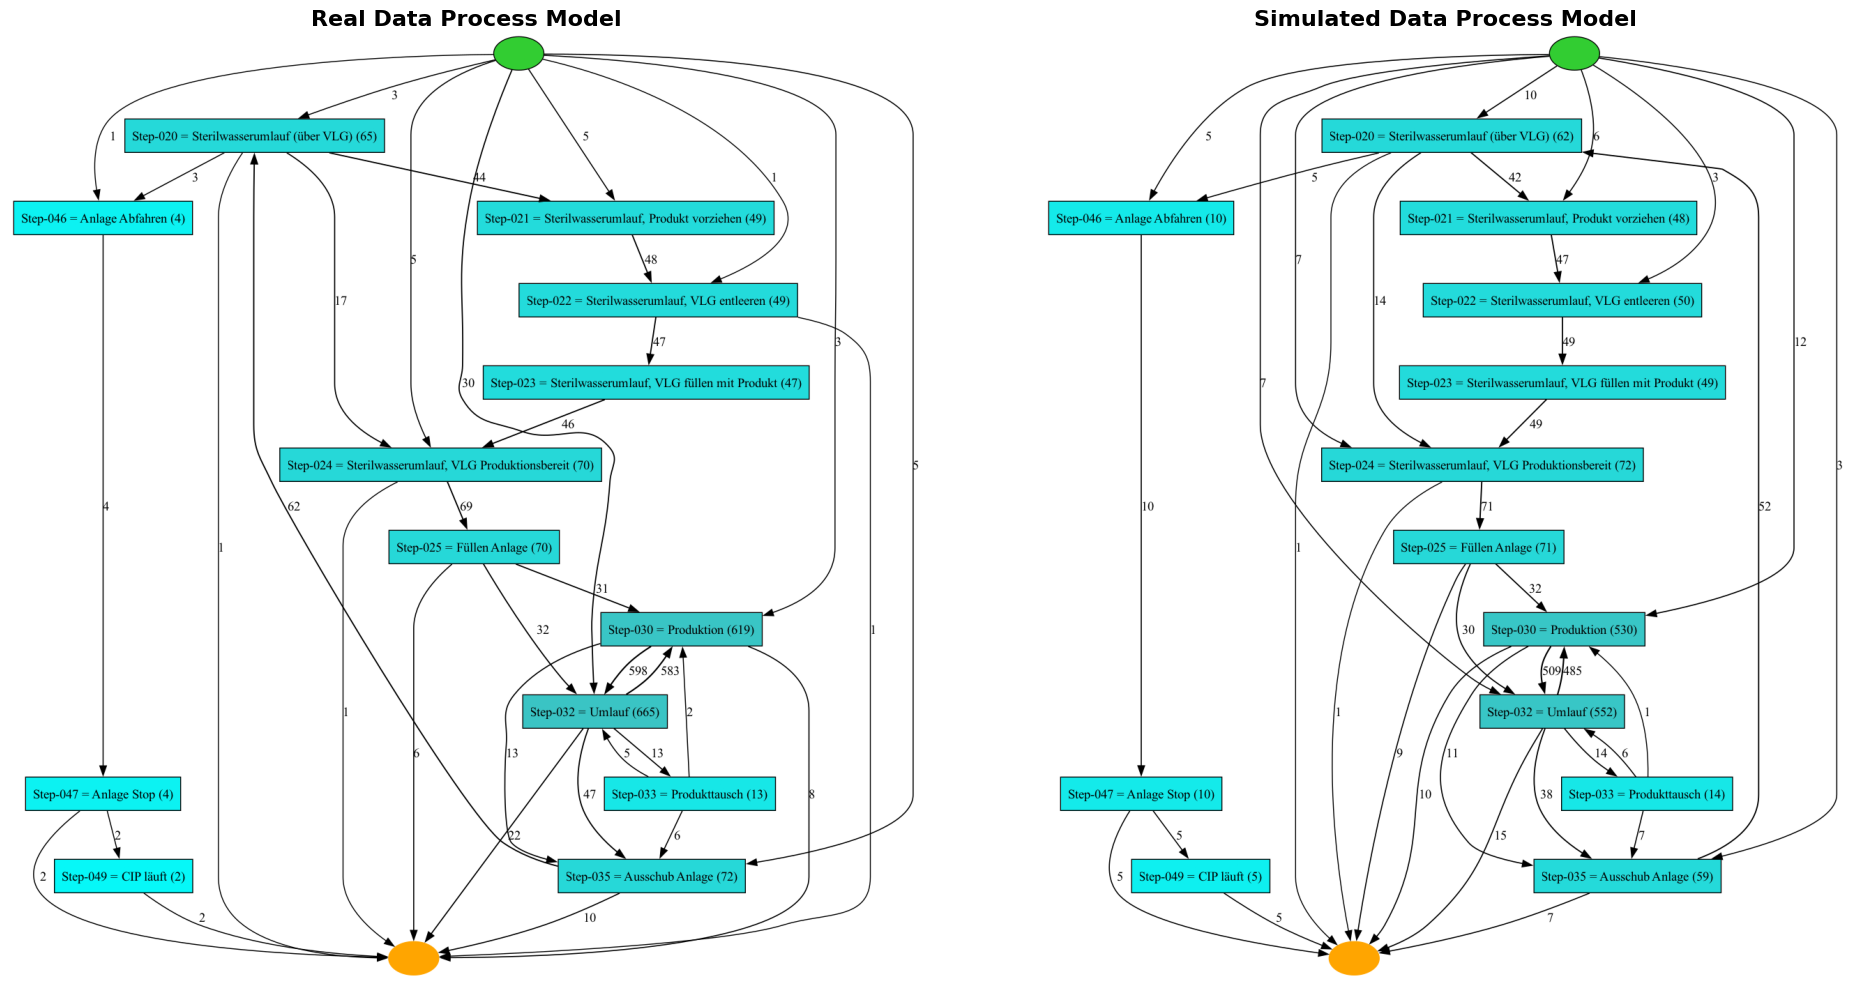

In [ ]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tempfile
import os

# Create temporary files for the visualizations
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_real, \
     tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_sim:
    
    temp_real_path = temp_real.name
    temp_sim_path = temp_sim.name

try:
    # Generate and save real data heuristic net
    df_real = df_compare.copy()
    event_log_real = pm4py.format_dataframe(df_real, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
    net_real = pm4py.discover_heuristics_net(event_log_real)
    pm4py.save_vis_heuristics_net(net_real, temp_real_path, bgcolor='white', dpi=500)
    
    # Generate and save simulated data heuristic net
    df_sim = simulated_log.copy()
    event_log_sim = pm4py.format_dataframe(df_sim, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
    net_sim = pm4py.discover_heuristics_net(event_log_sim)
    pm4py.save_vis_heuristics_net(net_sim, temp_sim_path, bgcolor='white', dpi=500)
    
    # Load and display side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Real data on the left
    img_real = mpimg.imread(temp_real_path)
    ax1.imshow(img_real)
    ax1.set_title('Real Data Process Model', fontsize=16, fontweight='bold')
    ax1.axis('off')
    
    # Simulated data on the right
    img_sim = mpimg.imread(temp_sim_path)
    ax2.imshow(img_sim)
    ax2.set_title('Simulated Data Process Model', fontsize=16, fontweight='bold')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
finally:
    # Clean up temporary files
    if os.path.exists(temp_real_path):
        os.unlink(temp_real_path)
    if os.path.exists(temp_sim_path):
        os.unlink(temp_sim_path)

In [ ]:
# Debug the simulated log first
print("Simulated log columns:", simulated_log.columns.tolist())
print("Simulated log shape:", simulated_log.shape)
print("\nFirst few rows:")
print(simulated_log.head())
print("\nActivity column type:", type(simulated_log['activity'].iloc[0]))
print("Sample activities:")
print(simulated_log['activity'].value_counts().head(10))

# Check for any problematic data
print("\nAny null values in key columns:")
print("case_id nulls:", simulated_log['case_id'].isnull().sum())
print("activity nulls:", simulated_log['activity'].isnull().sum()) 
print("timestamp_start nulls:", simulated_log['timestamp_start'].isnull().sum())

# Clean the data before creating the process map
df_clean = simulated_log.copy()

# Ensure proper data types
df_clean['case_id'] = df_clean['case_id'].astype(str)
df_clean['activity'] = df_clean['activity'].astype(str)
df_clean['timestamp_start'] = pd.to_datetime(df_clean['timestamp_start'])

# Remove any rows with missing essential data
df_clean = df_clean.dropna(subset=['case_id', 'activity', 'timestamp_start'])

print(f"\nCleaned data shape: {df_clean.shape}")
print("Sample activities after cleaning:")
print(df_clean['activity'].value_counts().head(10))

Simulated log columns: ['case_id', 'activity', 'timestamp_start', 'timestamp_end', 'object', 'object_type', 'higher_level_activity', 'object_attributes']
Simulated log shape: (1532, 8)

First few rows:
      case_id               activity            timestamp_start  \
0  10705690.0  Step-030 = Produktion 2024-08-01 09:58:56.000000   
1  10705690.0      Step-032 = Umlauf 2024-08-01 10:42:27.217900   
2  10705690.0  Step-030 = Produktion 2024-08-01 10:46:53.826176   
3  10705690.0      Step-032 = Umlauf 2024-08-01 10:59:24.434291   
4  10705690.0  Step-030 = Produktion 2024-08-01 11:03:15.299591   

               timestamp_end           object object_type  \
0 2024-08-01 10:42:26.217900  heating_machine    Erhitzer   
1 2024-08-01 10:46:52.826176  heating_machine    Erhitzer   
2 2024-08-01 10:59:23.434291  heating_machine    Erhitzer   
3 2024-08-01 11:03:14.299591  heating_machine    Erhitzer   
4 2024-08-01 12:32:41.294054  heating_machine    Erhitzer   

  higher_level_activity     

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import jensenshannon
from collections import Counter
import pm4py

def comprehensive_simulation_evaluation(simulated_df, real_df, case_col='case_id', 
                                       activity_col='activity', start_col='timestamp_start', 
                                       end_col='timestamp_end'):
    """
    Comprehensive evaluation of simulation quality based on process mining literature
    
    Metrics based on:
    - Rozinat et al. (2008): Conformance checking of processes based on monitoring real behavior
    - van der Aalst et al. (2010): Process mining manifesto
    - Burattin & Sperduti (2010): Automatic determination of parameters' values for heuristics miner++
    """
    
    results = {}
    
    print("="*80)
    print("COMPREHENSIVE SIMULATION EVALUATION")
    print("="*80)
    
    # ========== 1. BASIC PROCESS METRICS ==========
    print("\n1. BASIC PROCESS METRICS")
    print("-" * 40)
    
    # Event counts
    sim_events = len(simulated_df)
    real_events = len(real_df)
    event_ratio = sim_events / real_events if real_events > 0 else 0
    
    # Case counts  
    sim_cases = simulated_df[case_col].nunique()
    real_cases = real_df[case_col].nunique()
    case_ratio = sim_cases / real_cases if real_cases > 0 else 0
    
    print(f"Events - Real: {real_events}, Sim: {sim_events}, Ratio: {event_ratio:.3f}")
    print(f"Cases - Real: {real_cases}, Sim: {sim_cases}, Ratio: {case_ratio:.3f}")
    
    results['basic_metrics'] = {
        'event_count_ratio': event_ratio,
        'case_count_ratio': case_ratio,
        'event_count_error': abs(1 - event_ratio),
        'case_count_error': abs(1 - case_ratio)
    }
    
    # ========== 2. ACTIVITY FREQUENCY ANALYSIS ==========
    print("\n2. ACTIVITY FREQUENCY ANALYSIS")
    print("-" * 40)
    
    # Activity frequencies
    sim_activity_freq = simulated_df[activity_col].value_counts(normalize=True).sort_index()
    real_activity_freq = real_df[activity_col].value_counts(normalize=True).sort_index()
    
    # Align activities (handle missing activities)
    all_activities = set(sim_activity_freq.index) | set(real_activity_freq.index)
    sim_freq_aligned = pd.Series([sim_activity_freq.get(act, 0) for act in all_activities], index=all_activities)
    real_freq_aligned = pd.Series([real_activity_freq.get(act, 0) for act in all_activities], index=all_activities)
    
    # Jensen-Shannon divergence for activity distributions
    js_divergence = jensenshannon(sim_freq_aligned.values, real_freq_aligned.values)
    
    # Mean Absolute Error of frequencies
    freq_mae = np.mean(np.abs(sim_freq_aligned.values - real_freq_aligned.values))
    
    print(f"Activity Coverage - Real: {len(real_activity_freq)}, Sim: {len(sim_activity_freq)}")
    print(f"Jensen-Shannon Divergence (activities): {js_divergence:.4f} (0=perfect, 1=worst)")
    print(f"Mean Absolute Error (frequencies): {freq_mae:.4f}")
    
    results['activity_metrics'] = {
        'js_divergence': js_divergence,
        'frequency_mae': freq_mae,
        'activity_coverage_ratio': len(sim_activity_freq) / len(real_activity_freq) if len(real_activity_freq) > 0 else 0
    }
    
    # ========== 3. DURATION ANALYSIS ==========
    print("\n3. DURATION ANALYSIS")
    print("-" * 40)
    
    # Calculate durations
    sim_durations = (simulated_df[end_col] - simulated_df[start_col]).dt.total_seconds() / 60
    real_durations = (real_df[end_col] - real_df[start_col]).dt.total_seconds() / 60
    
    # Statistical comparison
    duration_ks_stat, duration_ks_pvalue = stats.ks_2samp(sim_durations, real_durations)
    
    # Duration statistics comparison
    duration_stats = pd.DataFrame({
        'Real': [real_durations.mean(), real_durations.median(), real_durations.std()],
        'Simulated': [sim_durations.mean(), sim_durations.median(), sim_durations.std()],
    }, index=['Mean', 'Median', 'Std'])
    
    duration_stats['Error'] = np.abs(duration_stats['Simulated'] - duration_stats['Real']) / duration_stats['Real']
    
    print("Duration Statistics:")
    print(duration_stats.round(3))
    print(f"\nKolmogorov-Smirnov Test: KS={duration_ks_stat:.4f}, p-value={duration_ks_pvalue:.4f}")
    print(f"(p > 0.05 suggests distributions are similar)")
    
    results['duration_metrics'] = {
        'ks_statistic': duration_ks_stat,
        'ks_pvalue': duration_ks_pvalue,
        'mean_duration_error': duration_stats.loc['Mean', 'Error'],
        'median_duration_error': duration_stats.loc['Median', 'Error'],
        'std_duration_error': duration_stats.loc['Std', 'Error']
    }
    
    # ========== 4. CASE-LEVEL ANALYSIS ==========
    print("\n4. CASE-LEVEL ANALYSIS")
    print("-" * 40)
    
    # Events per case
    sim_events_per_case = simulated_df.groupby(case_col).size()
    real_events_per_case = real_df.groupby(case_col).size()
    
    # Statistical test for events per case
    events_per_case_ks, events_per_case_pvalue = stats.ks_2samp(sim_events_per_case, real_events_per_case)
    
    case_stats = pd.DataFrame({
        'Real': [real_events_per_case.mean(), real_events_per_case.median(), real_events_per_case.std()],
        'Simulated': [sim_events_per_case.mean(), sim_events_per_case.median(), sim_events_per_case.std()],
    }, index=['Mean', 'Median', 'Std'])
    
    case_stats['Error'] = np.abs(case_stats['Simulated'] - case_stats['Real']) / case_stats['Real']
    
    print("Events per Case Statistics:")
    print(case_stats.round(3))
    print(f"\nKS Test (events per case): KS={events_per_case_ks:.4f}, p-value={events_per_case_pvalue:.4f}")
    
    results['case_metrics'] = {
        'events_per_case_ks': events_per_case_ks,
        'events_per_case_pvalue': events_per_case_pvalue,
        'mean_events_per_case_error': case_stats.loc['Mean', 'Error'],
        'median_events_per_case_error': case_stats.loc['Median', 'Error']
    }
    
    # ========== 5. CONTROL-FLOW ANALYSIS ==========
    print("\n5. CONTROL-FLOW ANALYSIS (Directly-Follows Graph)")
    print("-" * 40)
    
    # Create event logs for pm4py
    sim_log = pm4py.format_dataframe(simulated_df, case_id=case_col, activity_key=activity_col, timestamp_key=start_col)
    real_log = pm4py.format_dataframe(real_df, case_id=case_col, activity_key=activity_col, timestamp_key=start_col)
    
    # Discover DFGs
    sim_dfg, sim_start, sim_end = pm4py.discover_dfg(sim_log)
    real_dfg, real_start, real_end = pm4py.discover_dfg(real_log)
    
    # Compare DFG edges
    sim_edges = set(sim_dfg.keys())
    real_edges = set(real_dfg.keys())
    
    edge_precision = len(sim_edges & real_edges) / len(sim_edges) if len(sim_edges) > 0 else 0
    edge_recall = len(sim_edges & real_edges) / len(real_edges) if len(real_edges) > 0 else 0
    edge_f1 = 2 * (edge_precision * edge_recall) / (edge_precision + edge_recall) if (edge_precision + edge_recall) > 0 else 0
    
    print(f"DFG Edges - Real: {len(real_edges)}, Sim: {len(sim_edges)}, Common: {len(sim_edges & real_edges)}")
    print(f"Edge Precision: {edge_precision:.4f}")
    print(f"Edge Recall: {edge_recall:.4f}")
    print(f"Edge F1-Score: {edge_f1:.4f}")
    
    # Compare start/end activities (convert dict keys to sets)
    sim_start_set = set(sim_start.keys())
    real_start_set = set(real_start.keys())
    sim_end_set = set(sim_end.keys())
    real_end_set = set(real_end.keys())
    
    start_jaccard = len(sim_start_set & real_start_set) / len(sim_start_set | real_start_set) if len(sim_start_set | real_start_set) > 0 else 0
    end_jaccard = len(sim_end_set & real_end_set) / len(sim_end_set | real_end_set) if len(sim_end_set | real_end_set) > 0 else 0
    
    print(f"Start Activities Jaccard: {start_jaccard:.4f}")
    print(f"End Activities Jaccard: {end_jaccard:.4f}")
    
    results['control_flow_metrics'] = {
        'edge_precision': edge_precision,
        'edge_recall': edge_recall,
        'edge_f1_score': edge_f1,
        'start_activities_jaccard': start_jaccard,
        'end_activities_jaccard': end_jaccard
    }
    
    # ========== 6. OVERALL QUALITY SCORE ==========
    print("\n6. OVERALL QUALITY ASSESSMENT")
    print("-" * 40)
    
    # Weighted quality score (based on literature importance)
    quality_components = {
        'Event Count': (1 - results['basic_metrics']['event_count_error'], 0.15),
        'Activity Distribution': (1 - results['activity_metrics']['js_divergence'], 0.25),
        'Duration Distribution': (1 - results['duration_metrics']['ks_statistic'], 0.20),
        'Case Structure': (1 - results['case_metrics']['events_per_case_ks'], 0.15),
        'Control Flow': (results['control_flow_metrics']['edge_f1_score'], 0.25)
    }
    
    overall_score = sum(score * weight for (score, weight) in quality_components.values())
    
    print("Quality Components:")
    for component, (score, weight) in quality_components.items():
        print(f"  {component:20}: {score:.4f} (weight: {weight:.2f})")
    print(f"\nOVERALL QUALITY SCORE: {overall_score:.4f} (0=worst, 1=perfect)")
    
    if overall_score >= 0.8:
        quality_assessment = "EXCELLENT"
    elif overall_score >= 0.6:
        quality_assessment = "GOOD"
    elif overall_score >= 0.4:
        quality_assessment = "FAIR"
    else:
        quality_assessment = "POOR"
    
    print(f"QUALITY ASSESSMENT: {quality_assessment}")
    
    results['overall_score'] = overall_score
    results['quality_assessment'] = quality_assessment
    
    return results

🔍 RUNNING COMPREHENSIVE SIMULATION EVALUATION
Based on process mining literature (Rozinat et al., van der Aalst et al., Burattin & Sperduti)
COMPREHENSIVE SIMULATION EVALUATION

1. BASIC PROCESS METRICS
----------------------------------------
Events - Real: 1935, Sim: 1532, Ratio: 0.792
Cases - Real: 53, Sim: 53, Ratio: 1.000

2. ACTIVITY FREQUENCY ANALYSIS
----------------------------------------
Activity Coverage - Real: 20, Sim: 13
Jensen-Shannon Divergence (activities): 0.0803 (0=perfect, 1=worst)
Mean Absolute Error (frequencies): 0.0032

3. DURATION ANALYSIS
----------------------------------------
Duration Statistics:
          Real  Simulated  Error
Mean    15.526     17.755  0.144
Median   4.217      6.518  0.546
Std     48.613     39.857  0.180

Kolmogorov-Smirnov Test: KS=0.1632, p-value=0.0000
(p > 0.05 suggests distributions are similar)

4. CASE-LEVEL ANALYSIS
----------------------------------------
Events per Case Statistics:
          Real  Simulated  Error
Mean    32

/Users/davidzapata/miniconda3/envs/htp/lib/python3.10/site-packages/pm4py/utils.py:253: UserWarning:

Some rows of the Pandas data frame have been removed because of empty case IDs, activity labels, or timestamps to ensure the correct functioning of PM4Py's algorithms.

/var/folders/j7/bzg541gd7dg10j_2qvx3s4j00000gn/T/ipykernel_53798/2201761089.py:49: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/j7/bzg541gd7dg10j_2qvx3s4j00000gn/T/ipykernel_53798/2201761089.py:52: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False

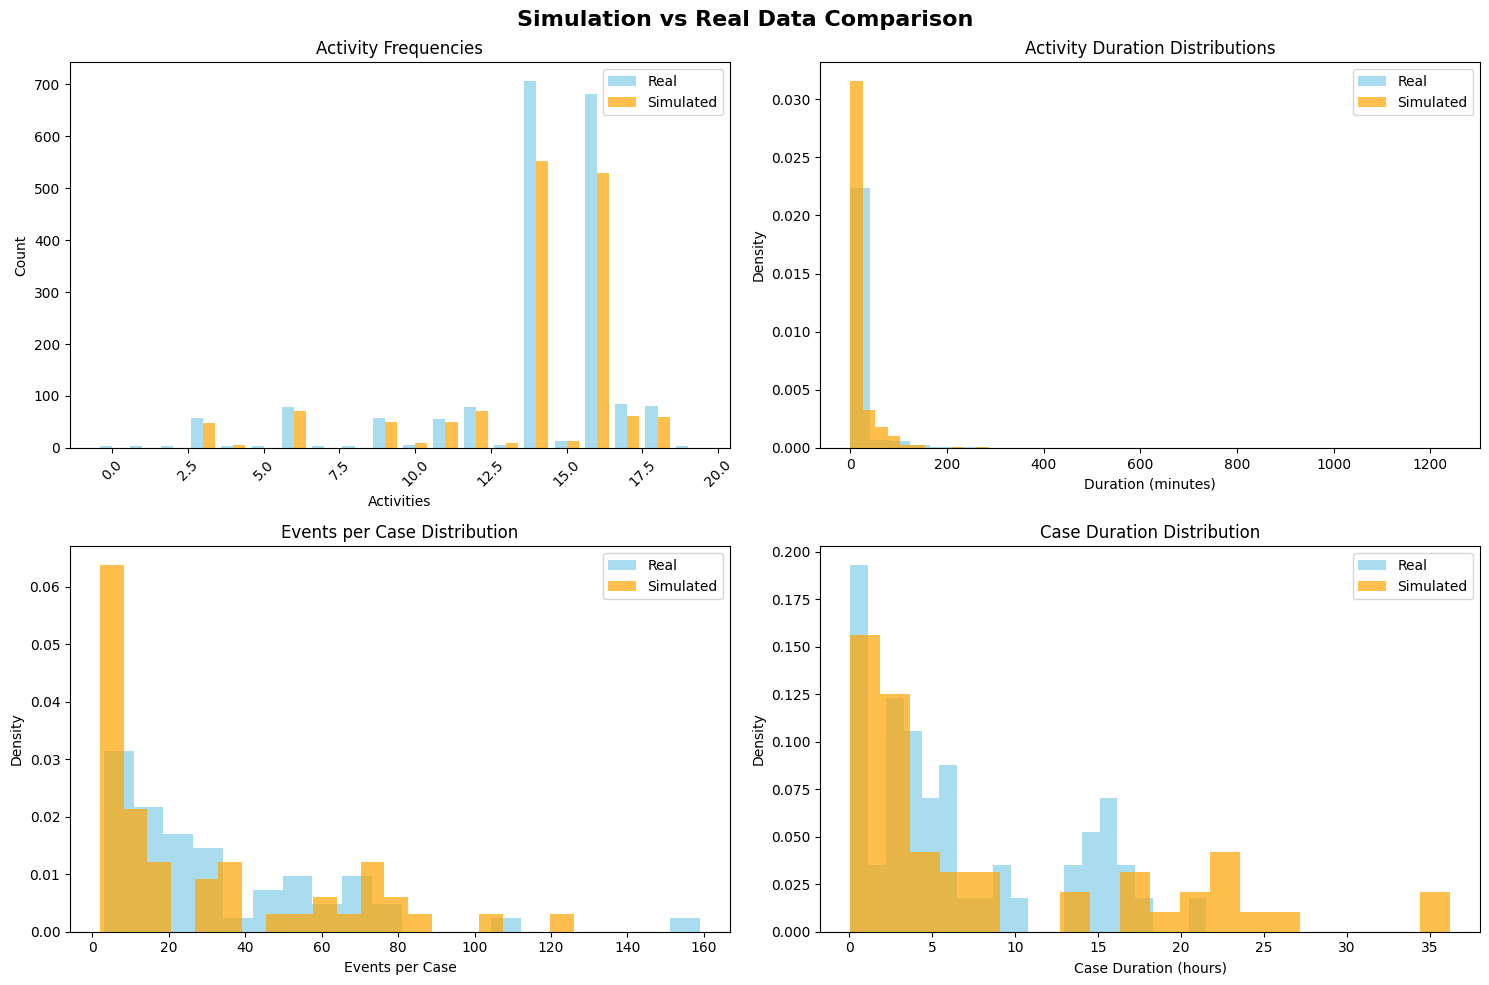

In [ ]:
def plot_simulation_comparison(simulated_df, real_df, case_col='case_id', 
                             activity_col='activity', start_col='timestamp_start', 
                             end_col='timestamp_end'):
    """Create detailed comparison plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Simulation vs Real Data Comparison', fontsize=16, fontweight='bold')
    
    # 1. Activity frequencies
    sim_freq = simulated_df[activity_col].value_counts()
    real_freq = real_df[activity_col].value_counts()
    
    all_activities = list(set(sim_freq.index) | set(real_freq.index))
    sim_aligned = [sim_freq.get(act, 0) for act in all_activities]
    real_aligned = [real_freq.get(act, 0) for act in all_activities]
    
    x = np.arange(len(all_activities))
    axes[0,0].bar(x - 0.2, real_aligned, 0.4, label='Real', alpha=0.7, color='skyblue')
    axes[0,0].bar(x + 0.2, sim_aligned, 0.4, label='Simulated', alpha=0.7, color='orange')
    axes[0,0].set_title('Activity Frequencies')
    axes[0,0].set_xlabel('Activities')
    axes[0,0].set_ylabel('Count')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Duration distributions
    sim_durations = (simulated_df[end_col] - simulated_df[start_col]).dt.total_seconds() / 60
    real_durations = (real_df[end_col] - real_df[start_col]).dt.total_seconds() / 60
    
    axes[0,1].hist(real_durations, alpha=0.7, label='Real', bins=30, density=True, color='skyblue')
    axes[0,1].hist(sim_durations, alpha=0.7, label='Simulated', bins=30, density=True, color='orange')
    axes[0,1].set_title('Activity Duration Distributions')
    axes[0,1].set_xlabel('Duration (minutes)')
    axes[0,1].set_ylabel('Density')
    axes[0,1].legend()
    
    # 3. Events per case
    sim_events_per_case = simulated_df.groupby(case_col).size()
    real_events_per_case = real_df.groupby(case_col).size()
    
    axes[1,0].hist(real_events_per_case, alpha=0.7, label='Real', bins=20, density=True, color='skyblue')
    axes[1,0].hist(sim_events_per_case, alpha=0.7, label='Simulated', bins=20, density=True, color='orange')
    axes[1,0].set_title('Events per Case Distribution')
    axes[1,0].set_xlabel('Events per Case')
    axes[1,0].set_ylabel('Density')
    axes[1,0].legend()
    
    # 4. Cumulative case duration
    sim_case_durations = simulated_df.groupby(case_col).apply(
        lambda x: (x[end_col].max() - x[start_col].min()).total_seconds() / 3600
    )
    real_case_durations = real_df.groupby(case_col).apply(
        lambda x: (x[end_col].max() - x[start_col].min()).total_seconds() / 3600
    )
    
    axes[1,1].hist(real_case_durations, alpha=0.7, label='Real', bins=20, density=True, color='skyblue')
    axes[1,1].hist(sim_case_durations, alpha=0.7, label='Simulated', bins=20, density=True, color='orange')
    axes[1,1].set_title('Case Duration Distribution')
    axes[1,1].set_xlabel('Case Duration (hours)')
    axes[1,1].set_ylabel('Density')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

# Run the comprehensive evaluation
print("🔍 RUNNING COMPREHENSIVE SIMULATION EVALUATION")
print("Based on process mining literature (Rozinat et al., van der Aalst et al., Burattin & Sperduti)")
print("="*80)

evaluation_results = comprehensive_simulation_evaluation(simulated_log, df_final_clean)

print("\n📊 GENERATING COMPARISON PLOTS")
plot_simulation_comparison(simulated_log, df_final_clean)

# Model the energy